In [ ]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 606 (delta 1), reused 5 (delta 0), pack-reused 598
Receiving objects: 100% (606/606), 29.82 MiB | 31.19 MiB/s, done.
Resolving deltas: 100% (361/361), done.


##신경망에서의 단어 처리

In [ ]:
import numpy as np

c = np.array([1,0,0,0,0,0,0]) #입력
W = np.random.randn(7,3) #가중치
h = np.matmul(c,W) #중간 노드
print(h)

[-0.32578616 -0.51917418 -0.14022099]


##CBOW 모델의 추론 처리

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

#샘플 맥락 데이터
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

#가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

#계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

#순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0+h1)
s = out_layer.forward(h)

print(s)

[[-1.64546404  2.83772312  2.5290467   1.13729314 -0.58329885  0.47245418
   0.82262868]]


##CBOW 학습

말뭉치 텍스트 → 단어 id

In [ ]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


맥락과 타깃 만들기

In [ ]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size+1):
      if t == 0:
        continue
      cs.append(corpus[idx+t])
    contexts.append(cs)

  return np.array(contexts), np.array(target)

In [ ]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


데이터준비 - 종합

In [ ]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

##CBOW 모델 구현

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V,H = vocab_size, hidden_size

    #가중치 초기화
    W_in = 0.01 * np.random.randn(V,H).astype('f')
    W_out = 0.01 * np.random.randn(H,V).astype('f')

    #계층 생성
    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    #모든 가중치와 기울기를 리스트에 모은다.
    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    #인스턴스 변수에 단어의 분산 표현을 저장한다.
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:,0])
    h1 = self.in_layer1.forward(contexts[:,1])
    h = (h0+h1)*0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

  def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

###CBOW 학습

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

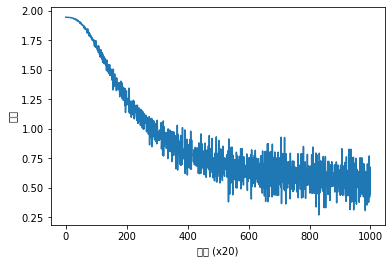

In [ ]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size=1
hidden_size=5
batch_size=3
max_epoch=1000

text='You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [ ]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [-1.3279481  1.1658043  1.0822699  1.1869739 -1.0455376]
say [ 1.2521454  -0.27553973 -1.2449183  -0.21902187  1.2333828 ]
goodbye [-0.5869353   0.74903065  0.8861152   0.72262484 -0.95957834]
and [ 1.0898613 -1.5849283 -1.0661561 -1.5983112  1.0482639]
i [-0.5924364   0.72744626  0.85978675  0.7089987  -0.92694   ]
hello [-1.3516234  1.1919094  1.0803144  1.2013798 -1.0608245]
. [ 1.0650024  1.4784317 -1.0786141  1.476973   1.0781051]


##Skip-Gram 구현

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None


##Skip-Gram 학습

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 3.87
| 에폭 26 |

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

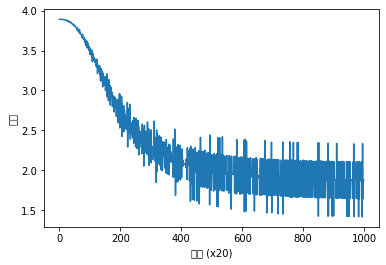

In [ ]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size=1
hidden_size=5
batch_size=3
max_epoch=1000

text='You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()